# Histopathologic Cancer Detection

In [ ]:
import os
import zipfile

os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!chmod 600 /content/kaggle.json
!kaggle competitions download -c histopathologic-cancer-detection
path_to_zip_file = '/content/histopathologic-cancer-detection.zip'
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall('/content/histopathologic-cancer-detection')

100% 6.31G/6.31G [04:04<00:00, 29.7MB/s]
100% 6.31G/6.31G [04:04<00:00, 27.7MB/s]


In [ ]:
!ls histopathologic-cancer-detection/

sample_submission.csv  test  train  train_labels.csv


#### Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
from torch import nn
import torchvision.models as models
from torchsummary import summary
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import roc_auc_score
from torch.optim.lr_scheduler import StepLR

### Read Train and Test Datasets

In [ ]:
train_data = pd.read_csv("/content/histopathologic-cancer-detection/train_labels.csv")
test_data = pd.read_csv("/content/histopathologic-cancer-detection/sample_submission.csv")
train_data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [ ]:
train_path = "/content/histopathologic-cancer-detection/train/"
test_path = "/content/histopathologic-cancer-detection/test/"

#### Distribution of DataSet

<Figure size 1296x1296 with 0 Axes>

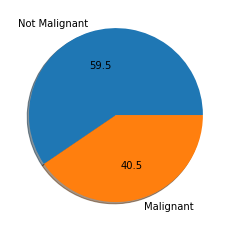

<Figure size 1296x1296 with 0 Axes>

In [ ]:
labels_count = train_data.label.value_counts()
plt.pie(labels_count, labels=['Not Malignant', 'Malignant'],autopct='%1.1f', shadow=True)
plt.figure(figsize=(18,18))

#### Display of some random images

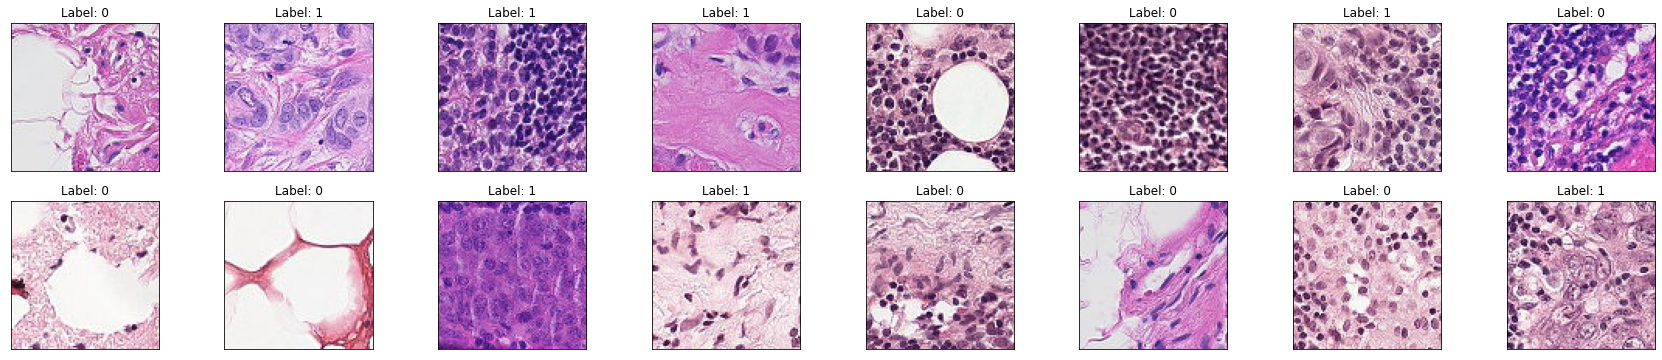

In [ ]:
fig = plt.figure(figsize=(30, 6))
# display 16 random images
imags = os.listdir(train_path)
for idx, img in enumerate(np.random.choice(imags, 16)):
    ax = fig.add_subplot(2,8, idx+1, xticks=[], yticks=[])
    im = Image.open(train_path + img)
    plt.imshow(im)
    lab = train_data.loc[train_data['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title('Label: %s'%lab)

#### Read Dataset

In [ ]:
class Dataset(Dataset):
    # read df, data directory and transformations
    def __init__(self, df_data, transform, data_dir = './'):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.tif')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

#### Apply transformation (Augmentations)

In [ ]:
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

final_train_data = Dataset(df_data=train_data, data_dir=train_path, transform=transforms_train)
final_test_data = Dataset(df_data=test_data, data_dir=test_path, transform=transforms_train)

len(final_train_data), len(final_test_data)

(220025, 57458)

#### Create train and valid datsets

In [ ]:
valid_size = 0.2
num_train = len(final_train_data)
indices = list(range(num_train))
# np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Create Samplers
train_df = SubsetRandomSampler(train_idx)
valid_df = SubsetRandomSampler(valid_idx)

batch_size = 128
train_loader = DataLoader(final_train_data, batch_size=batch_size, sampler=train_df)
valid_loader = DataLoader(final_train_data, batch_size=batch_size, sampler=valid_df)
test_loader = DataLoader(final_test_data, batch_size=batch_size, shuffle=False)

(len(train_loader)), (len(valid_loader)), len(test_loader)

(1376, 344, 449)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### Custom Model Architecture

In [ ]:
class PrintSize(nn.Module):
  def __init__(self):
    super(PrintSize, self).__init__()
    
  def forward(self, x):
    print(x.shape)
    return x

In [ ]:
import time

def train_model(model, num_epochs, train_loader, valid_loader, learning_rate=0.001, momentum=0.9):


    for epoch in range(1, num_epochs+1):
        from torch.optim import lr_scheduler
        print(time.ctime(), 'Epoch:', epoch)
    
        criterion = nn.BCEWithLogitsLoss()
        # SGD Optimizer is used
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
        # scheduler to learn the optim optimizer
        lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

        # Train set
        train_loss = []
        #lr_scheduler.step()
        train_aucuracy = []

        for batch_i, (data, target) in enumerate(train_loader):

            data, target = data.cuda(), target.cuda()

            # start SCD
            optimizer.zero_grad()
            # pred values
            output = model(data)
            # loss of output
            loss = criterion(output[:,1], target.float())
            # train loss
            train_loss.append(loss.item())
            
            true_v = target.data.cpu().numpy()
            pred_v = output[:,-1].detach().cpu().numpy()
            train_aucuracy.append(roc_auc_score(true_v, pred_v))

            loss.backward()
            optimizer.step()
        lr_scheduler.step()

        # Validation set
        model.eval()
        val_loss = []
        val_aucuracy = []

        for batch_i, (data, target) in enumerate(valid_loader):
            data, target = data.cuda(), target.cuda()
            output = model(data)

            loss = criterion(output[:,1], target.float())

            val_loss.append(loss.item()) 
            a = target.data.cpu().numpy()
            b = output[:,-1].detach().cpu().numpy()
            val_aucuracy.append(roc_auc_score(a, b))

        print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.3f}, valid loss: {np.mean(val_loss):.3f}, train auc: {np.mean(train_aucuracy):.3f}, valid acc: {np.mean(val_aucuracy):.3f}')

    return train_loss, val_loss, train_aucuracy, val_aucuracy

In [ ]:
# Basic Functions information
# conv2d params - in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None
# Output Shape Calculator you can use this formula [(W−K+2P)/S]+1.

      #W is the input volume - in your case 128
      #K is the Kernel size - in your case 5
      #P is the padding - in your case 0 i believe
      #S is the stride - which you have not provided.

model_custom = nn.Sequential(
    nn.Conv2d(3, 32, 3, 1, 1), # in_channels, out_channels, kernel_size, stride, padding
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 32, 3, 1, 1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 32, 3, 1, 1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(32),

    nn.MaxPool2d(2, stride=2), # torch.Size([128, 32, 48, 48])
    #PrintSize(),

    nn.Conv2d(32, 64, 3, 1, 1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, 3, 1, 1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 64, 3, 1, 1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(64),
    
    nn.MaxPool2d(2, stride=2), # torch.Size([128, 64, 24, 24])
    #PrintSize(),

    nn.Conv2d(64, 128, 3, 1, 1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(128),
    nn.Conv2d(128, 128, 3, 1, 1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(128),
    nn.Conv2d(128, 128, 3, 1, 1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(128),

    nn.MaxPool2d(2, stride=2), # torch.Size([128, 128, 12, 12])
    #PrintSize(), 

    nn.Conv2d(128, 256, 3, 1, 1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(256),
    nn.Conv2d(256, 256, 3, 1, 1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(256),
    nn.Conv2d(256, 256, 3, 1, 1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(256), 

    nn.MaxPool2d(2, stride=2), # torch.Size([128, 256, 6, 6])
    #PrintSize(),

    # lots of convolutions, pooling, etc.
    nn.Flatten(), # torch.Size([128, 9216]) here 9216 = 32*47*47
    #PrintSize(),
    nn.Linear(9216, 512), #the input dim of 1 is just a placeholder
    nn.ReLU(inplace=True),
    nn.Linear(512,10), # affine layer
    nn.ReLU(inplace=True),
    nn.Linear(10,2), # affine layer
    #PrintSize()
)

#### VGG16 Architecture

In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4608,128),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128,128),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(128,128))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

#### RESNET50 Model

In [ ]:
# set pretrained = True; which makes model to froze except for the last ‘fc’ layer, which we will modify
# using advantage of transfer learning
model_res50 = models.resnet50(pretrained=True)

# set requires_grad to false
for i, param in model_res50.named_parameters():
    param.requires_grad = False

# set final full collected layer
num_ftrs = model_res50.fc.in_features
model_res50.fc = nn.Linear(num_ftrs, 2)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Train Custom Model

In [ ]:
model_custom = model_custom.cuda()
train_loss, valid_loss, train_aucuracy, val_aucuracy = train_model(model_custom, 11, train_loader, valid_loader)

Sun Nov 13 03:21:59 2022 Epoch: 1
Epoch 1, train loss: 0.179, valid loss: 0.217, train auc: 0.980, valid acc: 0.978
Sun Nov 13 03:25:06 2022 Epoch: 2
Epoch 2, train loss: 0.169, valid loss: 0.162, train auc: 0.982, valid acc: 0.982
Sun Nov 13 03:28:13 2022 Epoch: 3
Epoch 3, train loss: 0.160, valid loss: 0.169, train auc: 0.984, valid acc: 0.983
Sun Nov 13 03:31:20 2022 Epoch: 4
Epoch 4, train loss: 0.154, valid loss: 0.156, train auc: 0.985, valid acc: 0.984
Sun Nov 13 03:34:27 2022 Epoch: 5
Epoch 5, train loss: 0.149, valid loss: 0.147, train auc: 0.986, valid acc: 0.985
Sun Nov 13 03:37:34 2022 Epoch: 6
Epoch 6, train loss: 0.144, valid loss: 0.181, train auc: 0.987, valid acc: 0.985
Sun Nov 13 03:40:41 2022 Epoch: 7
Epoch 7, train loss: 0.139, valid loss: 0.174, train auc: 0.988, valid acc: 0.984
Sun Nov 13 03:43:48 2022 Epoch: 8
Epoch 8, train loss: 0.136, valid loss: 0.138, train auc: 0.988, valid acc: 0.987
Sun Nov 13 03:46:56 2022 Epoch: 9
Epoch 9, train loss: 0.131, valid loss

#### Train VGG16 Model

In [ ]:
num_classes = 100
model_vgg = VGG16(num_classes).to(device)

train_loss_vgg, valid_loss_vgg, train_aucuracy_vgg, val_aucuracy_vgg = train_model(model_vgg, 3, train_loader, valid_loader)

Sun Nov 13 02:51:17 2022 Epoch: 1
Epoch 1, train loss: 0.354, valid loss: 0.361, train auc: 0.777, valid acc: 0.916
Sun Nov 13 02:54:43 2022 Epoch: 2
Epoch 2, train loss: 0.333, valid loss: 0.289, train auc: 0.538, valid acc: 0.457
Sun Nov 13 02:58:03 2022 Epoch: 3
Epoch 3, train loss: 0.273, valid loss: 0.243, train auc: 0.656, valid acc: 0.654


#### Train RESNET50

In [ ]:
model_res50.cuda()
train_loss_res, valid_loss_res, train_aucuracy_res, val_aucuracy_res = train_model(model_res50, 11, train_loader, valid_loader)

Sun Nov 13 04:30:16 2022 Epoch: 1
Epoch 1, train loss: 0.370, valid loss: 0.368, train auc: 0.910, valid acc: 0.910
Sun Nov 13 04:33:25 2022 Epoch: 2
Epoch 2, train loss: 0.365, valid loss: 0.364, train auc: 0.913, valid acc: 0.913
Sun Nov 13 04:36:35 2022 Epoch: 3
Epoch 3, train loss: 0.361, valid loss: 0.367, train auc: 0.915, valid acc: 0.913
Sun Nov 13 04:39:45 2022 Epoch: 4
Epoch 4, train loss: 0.359, valid loss: 0.363, train auc: 0.915, valid acc: 0.915
Sun Nov 13 04:42:54 2022 Epoch: 5
Epoch 5, train loss: 0.357, valid loss: 0.357, train auc: 0.916, valid acc: 0.916
Sun Nov 13 04:46:04 2022 Epoch: 6
Epoch 6, train loss: 0.356, valid loss: 0.355, train auc: 0.917, valid acc: 0.916
Sun Nov 13 04:49:14 2022 Epoch: 7
Epoch 7, train loss: 0.354, valid loss: 0.361, train auc: 0.918, valid acc: 0.917
Sun Nov 13 04:52:23 2022 Epoch: 8
Epoch 8, train loss: 0.354, valid loss: 0.354, train auc: 0.918, valid acc: 0.918
Sun Nov 13 04:55:35 2022 Epoch: 9
Epoch 9, train loss: 0.351, valid loss

#### Selected Model - Custom Model

Addition of Normalization and RandomFlips has increased the accuarcy of the model.

#### Calculate Predictions on Test Data

In [ ]:
def predictions(model, loader):
    acc_list = []
    print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        x_var = x.cuda()

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
    return preds